In [1]:
# data manipulation and plotting
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# for saving the pipeline
import joblib

# from scikit-learn
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# from feature engine
from feature_engine.selection import DropFeatures
from feature_engine.encoding import RareLabelEncoder

# created in-house
import preprocessors as pp

In [2]:
# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

In [3]:
# load dataset
data = pd.read_csv('CarPrice_db.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(205, 26)


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romeo,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romeo,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romeo,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [4]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['car_ID','enginelocation','enginetype','price'],axis=1), 
    data['price'], 
    test_size=0.3, 
    random_state=0)

In [5]:
X_train.shape, X_test.shape

((143, 22), (62, 22))

In [6]:
REMAP_VARS = ['symboling']

CAR_VAR = 'CarName'

BINARY_VARS = ['fueltype', 
               'aspiration', 
               'doornumber']

NON_BINARY_VARS = ['CarName', 
                   'carbody', 
                   'drivewheel', 
                   'cylindernumber', 
                   'fuelsystem',
                   ]

CAT_VARS = BINARY_VARS + NON_BINARY_VARS

SCALED_FEATURES = ['symboling',
                   'CarName',
                   'carbody',
                   'drivewheel',
                   'wheelbase',
                   'carlength',
                   'carwidth',
                   'carheight',
                   'curbweight',
                   'cylindernumber',
                   'enginesize',
                   'fuelsystem',
                   'boreratio',
                   'stroke',
                   'compressionratio',
                   'horsepower',
                   'peakrpm',
                   'citympg',
                   'highwaympg']

TARGET = 'price'

DROPPED_FEATURES = ['stroke', 
                'compressionratio', 
                'peakrpm', 
                'doornumber_two']

In [7]:
price_pipe = Pipeline([
    
    # ===== REMAP SYMBOLING =====
    # reassign the value to reflect domain reality
    ('remap_symboling', pp.RemapVariable(variab les=REMAP_VARS)),
    
    # ===== CAR NAME =====
    # collapse the cardinality of the column
    ('collapse_carname', pp.CarTransform(variable=CAR_VAR)),
    
    # ===== RARE LABELS =====
    # group categories present in less than 1% of obs.
    ('rare_label_encoder', RareLabelEncoder(
        tol=0.01, n_categories=1, variables=CAT_VARS)),
    
    # ===== CATEGORICAL ENCODER =====
    # one-hot encode binary variables
    ('binary_encoder', pp.CategoricalEncoder(variables=BINARY_VARS)),
    
    # encoding of non-binary variables
    ('non_binary_encoder', pp.OrdinalEncoder(
        variables=NON_BINARY_VARS, target=TARGET)),
    
    # ===== SCALER =====
    # scale the continuous variables
    ('scaler', pp.ContinuousScaler(variables=SCALED_FEATURES)),
    
    # ===== DROP FEATURES =====
    # reduce dataset to selected features
    ('drop_features', DropFeatures(features_to_drop=DROPPED_FEATURES)),
    
    # ===== TRAIN MODEL =====
    ('lasso', Lasso(alpha=0.001, random_state=0)),
    
])

In [8]:
price_pipe.fit(X_train, y_train)

Pipeline(steps=[('remap_symboling',
                 <preprocessors.RemapVariable object at 0x11d48cc10>),
                ('collapse_carname',
                 <preprocessors.CarTransform object at 0x11d48c460>),
                ('rare_label_encoder',
                 RareLabelEncoder(n_categories=1, tol=0.01,
                                  variables=['fueltype', 'aspiration',
                                             'doornumber', 'CarName', 'carbody',
                                             'drivewheel', 'cylindernumber',
                                             'fuelsystem'])),
                ('binary_encoder',
                 <preprocessors.CategoricalEncoder object at 0x11d48cd00>),
                ('non_binary_encoder',
                 <preprocessors.OrdinalEncoder object at 0x11d48cdf0>),
                ('scaler',
                 <preprocessors.ContinuousScaler object at 0x11d48cf40>),
                ('drop_features',
                 DropFeatures(features_

In [9]:
# evaluate the model:
# ====================

# make predictions for test set
pred = price_pipe.predict(X_test)

# determine mse, rmse and r2
print(f'test mse: {int(mean_squared_error(y_test, pred))}')
print(f'test rmse: {(int(mean_squared_error(y_test, pred)))**0.5}')
print(f'test r2: {r2_score(y_test, pred)}')
print()

print(f'Average grade score: {y_train.median()}')

test mse: 12707503
test rmse: 3564.7584770921017
test r2: 0.8075710303102351

Average grade score: 10245.0


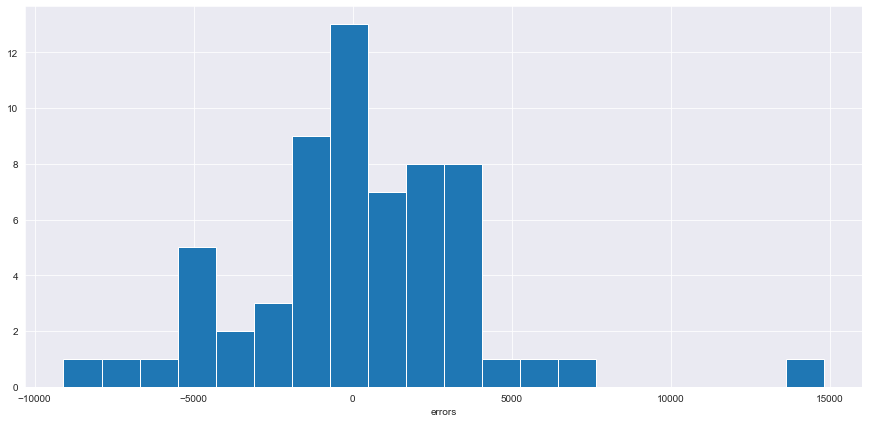

In [10]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

errors = y_test - pred

plt.figure(figsize=(15,7))
errors.hist(bins=20)
plt.xlabel('errors')
plt.show()

Notice the model is more conservative than optimisitic with its estimates. There are more instances of estimating below the actual values than otherwise but the error distribution is fairly normal and centered around 0. We can conclude that our model gets it right more times than it doesn't.

Text(0.5, 0, 'predictions')

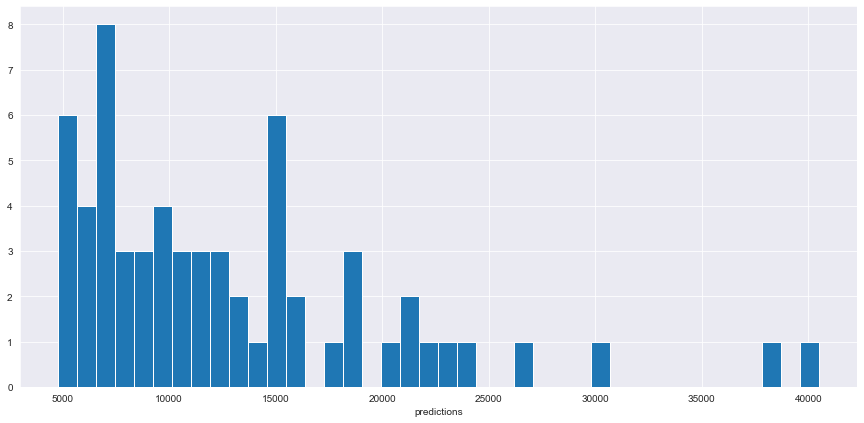

In [11]:
# plot out the predictions
plt.figure(figsize=(15,7))
pd.Series(pred).hist(bins=40)
plt.xlabel('predictions')

Notice how the distribution of the predictions closely mirrors the distribution of the actual car prices we analysed in the first notebook. 

In [12]:
# now let's save the model

joblib.dump(price_pipe, 'price_pipe.joblib') 

['price_pipe.joblib']

We are ready for deployment!